In [9]:
#Imports
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split

#Import de SHAP
import tensorflow
import numpy as np
import shap
import xgboost as xgb
# Ensuring Reproducibility
SEED = 12345

In [10]:
# Creación del conjunto de datos de entreno y de test
dataset = pd.read_csv(('./datasets/method.csv'), index_col = 'Hash')
features = ["CC","CCL","CCO","CI","CLC","CLLC","LDC","LLDC","HCPL","HDIF","HEFF","HNDB","HPL","HPV","HTRP","HVOL","MI","MIMS","MISEI","MISM","McCC","NL","NLE","NII","NOI","CD","CLOC","DLOC","TCD","TCLOC","LLOC","LOC","NOS","NUMPAR","TLLOC","TLOC","TNOS","WarningBlocker","WarningCritical","WarningInfo","WarningMajor","WarningMinor","Android Rules","Basic Rules","Brace Rules","Clone Implementation Rules","Code Size Rules","Comment Rules","Controversial Rules","Coupling Rules","Design Rules","Empty Code Rules","Finalizer Rules","Import Statement Rules","J2EE Rules","JUnit Rules","Jakarta Commons Logging Rules","Java Logging Rules","JavaBean Rules","MigratingToJUnit4 Rules","Migration Rules","Migration13 Rules","Migration14 Rules","Migration15 Rules","Naming Rules","Optimization Rules","Security Code Guideline Rules","Strict Exception Rules","String and StringBuffer Rules","Type Resolution Rules","Unnecessary and Unused Code Rules","Vulnerability Rules"]
salida = "Buggy"
Y = dataset[salida]
X = dataset.loc[:, features]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Combinar y exportar los conjuntos de entrenamiento y testeo
# train_df = pd.concat([X_train, y_train], axis=1)
# test_df = pd.concat([X_test, y_test], axis=1)
# train_df.to_csv('train_method.csv')
# test_df.to_csv('test_method.csv')

categorical = pd.Categorical(y_train)
y_train = categorical.codes
categorical = pd.Categorical(y_test)
y_test = categorical.codes	

In [11]:
# read in the split dataset into an optimized data structure called Dmatrix required by XGBoost
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

# Feed the model the global bias
base_score = np.mean(y_train)

## Modelo 1

[0]	X_train-logloss:0.62355	X_test-logloss:0.62283
[100]	X_train-logloss:0.60204	X_test-logloss:0.60339
[200]	X_train-logloss:0.59504	X_test-logloss:0.59805
[300]	X_train-logloss:0.59126	X_test-logloss:0.59594
[400]	X_train-logloss:0.58861	X_test-logloss:0.59471
[500]	X_train-logloss:0.58613	X_test-logloss:0.59380
[600]	X_train-logloss:0.58410	X_test-logloss:0.59318
[700]	X_train-logloss:0.58228	X_test-logloss:0.59266
[800]	X_train-logloss:0.58047	X_test-logloss:0.59231
[900]	X_train-logloss:0.57874	X_test-logloss:0.59192
[1000]	X_train-logloss:0.57707	X_test-logloss:0.59157
[1100]	X_train-logloss:0.57545	X_test-logloss:0.59121
[1160]	X_train-logloss:0.57455	X_test-logloss:0.59103


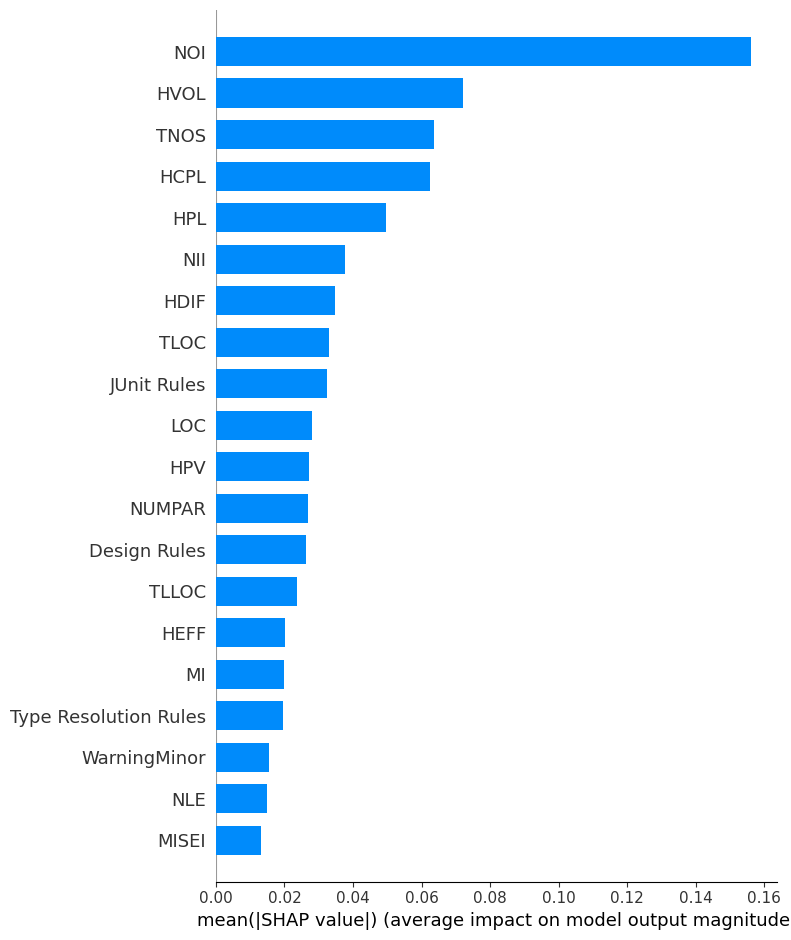

In [12]:
#Set hyperparameters for model training
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.01,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score,
    'tree_method': "gpu_hist", # GPU accelerated training
    'seed': SEED, 
    "predictor": "gpu_predictor"
}

# Train using early stopping on the validation dataset.
watchlist = [(d_train, 'X_train'), (d_test, 'X_test')]

model_gpu = xgb.train(params,         
                        d_train,                   
                        num_boost_round=5000,                     
                        evals=watchlist,
                        early_stopping_rounds=10,
                        verbose_eval=100)
explainer_gpu = shap.TreeExplainer(model=model_gpu)
shap_values_gpu = explainer_gpu.shap_values(X_test, check_additivity=False)
shap.initjs()
shap.summary_plot(shap_values_gpu, X_test, plot_type="bar")


## Modelo 2

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


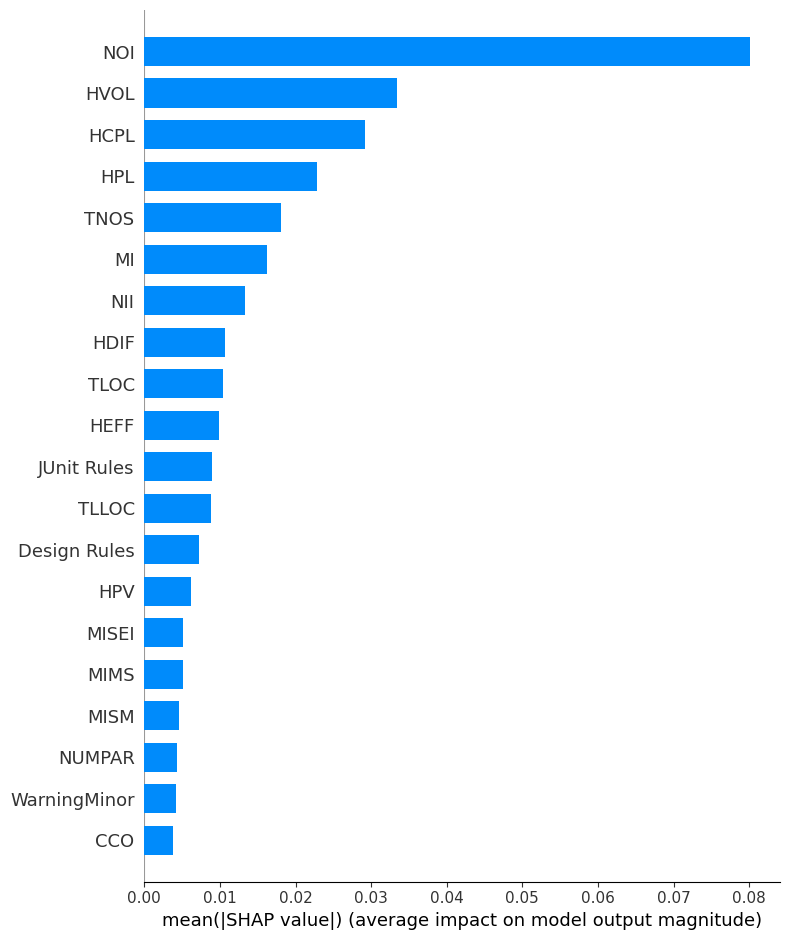

In [13]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
	eval_metric='logloss',
	eta=0.01,
	subsample=0.5,
	colsample_bytree=0.8,
	max_depth=5,
	base_score=base_score,
	tree_method="gpu_hist",
	seed=SEED, 
	predictor="gpu_predictor", 
)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## Prediccionees individuales 

In [14]:
# By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class. We can easily convert them to binary class values by rounding them to 0 or 1.

classes = {0 : 'Sin Bugs', 1: 'Buggy'}
prediction = model_gpu.predict(d_test)
# Model Prediction
y_pred = [round(value) for value in prediction]
classes[y_pred[0]]
display(prediction)
print(len(shap_values_gpu))
shap_values_gpu[1].shape

array([0.25206554, 0.38423043, 0.34855115, ..., 0.29158512, 0.40012586,
       0.28455386], dtype=float32)

32432


(72,)

# Nuevo comienzo

In [15]:
## Load Data and preparing datasets

# Import for Load Data
from os import listdir
from os.path import isfile, join
import pandas as pd

# Import for Split Data into Training and Testing Samples
from sklearn.model_selection import train_test_split

# Import for Construct a black-box model (Regression and Random Forests)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Import libraries for SHAP
import subprocess
import sys
import importlib
import numpy
import shap

In [16]:
train_dataset = pd.read_csv(('./datasets/train_method.csv'), index_col = 'Hash')
test_dataset = pd.read_csv(('./datasets/test_method.csv'), index_col = 'Hash')
print(train_dataset.columns.tolist())
# train_dataset['Hash'] = train_dataset['Hash'].astype(str)
# test_dataset['Hash'] = test_dataset['Hash'].astype(str)
train_dataset.index = train_dataset.index.map(str)
test_dataset.index = test_dataset.index.map(str)

outcome = 'Buggy'
features = ["CC","CCL","CCO","CI","CLC","CLLC","LDC","LLDC","HCPL","HDIF","HEFF","HNDB","HPL","HPV","HTRP","HVOL","MI","MIMS","MISEI","MISM","McCC","NL","NLE","NII","NOI","CD","CLOC","DLOC","TCD","TCLOC","LLOC","LOC","NOS","NUMPAR","TLLOC","TLOC","TNOS","WarningBlocker","WarningCritical","WarningInfo","WarningMajor","WarningMinor","Android Rules","Basic Rules","Brace Rules","Clone Implementation Rules","Code Size Rules","Comment Rules","Controversial Rules","Coupling Rules","Design Rules","Empty Code Rules","Finalizer Rules","Import Statement Rules","J2EE Rules","JUnit Rules","Jakarta Commons Logging Rules","Java Logging Rules","JavaBean Rules","MigratingToJUnit4 Rules","Migration Rules","Migration13 Rules","Migration14 Rules","Migration15 Rules","Naming Rules","Optimization Rules","Security Code Guideline Rules","Strict Exception Rules","String and StringBuffer Rules","Type Resolution Rules","Unnecessary and Unused Code Rules","Vulnerability Rules"]

# features = ["NOI","HCPL","TNOS","HVOL","HEFF","HDIF","NII","HPL","NUMPAR","JUnit Rules","LOC","HPV","Design Rules","TLOC","McCC","Type Resolution Rules","MI","WarningMinor","TLLOC","MISEI"]


# process outcome to 0 and 1
train_dataset[outcome] = pd.Categorical(train_dataset[outcome])
train_dataset[outcome] = train_dataset[outcome].cat.codes

test_dataset[outcome] = pd.Categorical(test_dataset[outcome])
test_dataset[outcome] = test_dataset[outcome].cat.codes

X_train = train_dataset.loc[:, features]
X_test = test_dataset.loc[:, features]

y_train = train_dataset.loc[:, outcome]
y_test = test_dataset.loc[:, outcome]

X_train.columns = features
X_test.columns = features
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)


['CC', 'CCL', 'CCO', 'CI', 'CLC', 'CLLC', 'LDC', 'LLDC', 'HCPL', 'HDIF', 'HEFF', 'HNDB', 'HPL', 'HPV', 'HTRP', 'HVOL', 'MI', 'MIMS', 'MISEI', 'MISM', 'McCC', 'NL', 'NLE', 'NII', 'NOI', 'CD', 'CLOC', 'DLOC', 'TCD', 'TCLOC', 'LLOC', 'LOC', 'NOS', 'NUMPAR', 'TLLOC', 'TLOC', 'TNOS', 'WarningBlocker', 'WarningCritical', 'WarningInfo', 'WarningMajor', 'WarningMinor', 'Android Rules', 'Basic Rules', 'Brace Rules', 'Clone Implementation Rules', 'Code Size Rules', 'Comment Rules', 'Controversial Rules', 'Coupling Rules', 'Design Rules', 'Empty Code Rules', 'Finalizer Rules', 'Import Statement Rules', 'J2EE Rules', 'JUnit Rules', 'Jakarta Commons Logging Rules', 'Java Logging Rules', 'JavaBean Rules', 'MigratingToJUnit4 Rules', 'Migration Rules', 'Migration13 Rules', 'Migration14 Rules', 'Migration15 Rules', 'Naming Rules', 'Optimization Rules', 'Security Code Guideline Rules', 'Strict Exception Rules', 'String and StringBuffer Rules', 'Type Resolution Rules', 'Unnecessary and Unused Code Rules'

In [17]:
## Construct a black-box model (Regression and Random Forests)

# random forests
rf_model = RandomForestClassifier(random_state=1234, n_jobs = 10)
rf_model.fit(X_train, y_train)  

RandomForestClassifier(n_jobs=10, random_state=1234)

In [18]:
# select an instance to explain
explain_file = '1'
explain_index = list(X_test.index).index(explain_file)
print(explain_file, 'is likely to be defective with a probability of', rf_model.predict_proba(X_test.loc[X_test.index == explain_file, :])[0][1])

# construct a SHAP explainer
explainer = shap.KernelExplainer(rf_model.predict, X_test)


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Using 32432 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


1 is likely to be defective with a probability of 0.25


In [19]:
# # generate shap values of testing data
# shap_values = explainer.shap_values(X_test.iloc[explain_index, :])

# # generate textual explanation of SHAP
# for i in range(0, len(features)):
#     print(features[i], 'SHAP score =', shap_values[i])

# # visualize a SHAP local explanation of the instance
# shap.initjs()
# shap.force_plot(explainer.expected_value, 
#                 shap_values, 
#                 X_test.iloc[explain_index,:])

## Lo mismo pero con XGBoost

In [20]:
## Construct a black-box model (Regression and Random Forests)
# random forests
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
	eval_metric='logloss',
	eta=0.01,
	subsample=0.5,
	colsample_bytree=0.8,
	max_depth=5,
	base_score=np.mean(y_train),
	tree_method="gpu_hist",
	seed=SEED
	# predictor="gpu_predictor", 
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.3165684383011338, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [26]:
from sklearn.metrics import classification_report
# select an instance to explain
explain_file = '1'
explain_index = list(X_test.index).index(explain_file)
print(explain_file, 'is likely to be defective with a probability of', xgb_model.predict_proba(X_test.loc[X_test.index == explain_file, :])[0][1])
predictions = xgb_model.predict(X_test)
classification = classification_report(y_test, predictions)
display(predictions)
# construct a SHAP explainer
xgb_explainer = shap.KernelExplainer(xgb_model.predict, X_test)

1 is likely to be defective with a probability of 0.3481657


array([0, 0, 0, ..., 0, 0, 0])

Using 32432 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [22]:
# generate shap values of testing data
xgb_shap_values = xgb_explainer.shap_values(X_test.iloc[explain_index, :])

# generate textual explanation of SHAP
for i in range(0, len(features)):
    print(features[i], 'SHAP score =', xgb_shap_values[i])

# visualize a SHAP local explanation of the instance
shap.initjs()
shap.force_plot(xgb_explainer.expected_value, 
                xgb_shap_values, 
                X_test.iloc[explain_index,:])

KeyboardInterrupt: 